# Trabajo Rompecabezas por Pablo Ascorbe

In [1]:
pip install pygame

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import matplotlib.pylab as plt
import random
import pygame, sys, os
from PIL import Image

pygame 2.1.2 (SDL 2.0.18, Python 3.9.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


IMPORTANTE:
<br>
Este trabajo, al usar una interfaz gráfica, es necesario que se ejecute en local. Es decir, si se intenta ejecutar desde Google Collab dará problemas.

Primero necesitamos un método que divida una imagen en las filas y columnas deseadas:

In [2]:
def dividir_imagen(imagen, filas, columnas):
    res = dividir_columnas( dividir_filas(imagen, filas), columnas)
    return [item for sublist in res for item in sublist]

In [3]:
def dividir_filas(imagen, filas):
    #Guardamos la dimension de las filas y calculamos el resto
    shape_0 = imagen.shape[0]
    restoFilas = shape_0%filas
    #Si la división no es exacta, significa que necesitamos rellenar con píxeles
    #negros, a través de la diferencia entre el resto y el número de filas.
    if restoFilas != 0:
        dif = filas - restoFilas
        shape_0 += dif
        #Si además esa diferencia no es par, necesitamos añadirle a una porción
        #más negros que a otra
        if dif%2 != 0:
            arriba = dif//2
            abajo = dif-arriba
        else:
            arriba, abajo = dif//2, dif//2
        #Con esto resuelto creamos las filas de negros, añadimos la imagen y 
        #terminamos de rellenar con negros.
        res = np.zeros((arriba, imagen.shape[1], imagen.shape[2]), dtype=int)
        res = np.append(res, np.copy(imagen), axis=0)
        res = np.append(res, np.zeros((abajo, imagen.shape[1], imagen.shape[2]), dtype=int), axis=0)
    else:
        res = np.copy(imagen)
    #Calculamos cuantas filas entran en cada porción
    cocienteFilas = shape_0//filas
    #comprobamos si tiene sentido rebanar
    if cocienteFilas == shape_0:
        return res
    else:
        #Y rebanamos
        return np.split(res, list(range(cocienteFilas, (cocienteFilas*filas)+1, cocienteFilas)))[:-1]

In [4]:
#El funcionamiento es identico a filas, pero en este caso es ir aplicándolo 
#por columnas a cada elemento de nuestra lista de filas.
def dividir_columnas(listaFilas, columnas):
    shape_1 = listaFilas[0].shape[1]
    restoColumnas = shape_1%columnas
    if restoColumnas != 0:
        dif = columnas - restoColumnas
        shape_1 += dif
        if dif%2 != 0:
            arriba = dif//2
            abajo = dif-arriba
        else:
            arriba, abajo = dif//2, dif//2
        aux = []
        for elem in listaFilas:
            res = np.zeros((elem.shape[0], arriba, elem.shape[2]), dtype=int)
            res = np.append(res, np.copy(elem), axis=1)
            aux.append(np.append(res, np.zeros((elem.shape[0], abajo, elem.shape[2]), dtype=int), axis=1))
        listaFilas = aux
    cocienteColumnas = shape_1//columnas
    if cocienteColumnas == shape_1:
        return listaFilas
    else:
        return [np.split(listaFilas[i], list(range(cocienteColumnas, (cocienteColumnas*columnas)+1, cocienteColumnas)), axis=1)[:-1] for i in range(len(listaFilas))]

In [202]:
import skimage

lista = dividir_imagen(skimage.data.coffee(), 10, 10)

Creamos una función auxiliar para mostrar los resultados:

In [6]:
def mostrar_casillas(lista, filas, columnas):
    fig = plt.figure(figsize=(8, 8))
    for i in range(0, filas*columnas):
        fig.add_subplot(filas,columnas,i+1)
        plt.imshow(lista[i])
    plt.show()

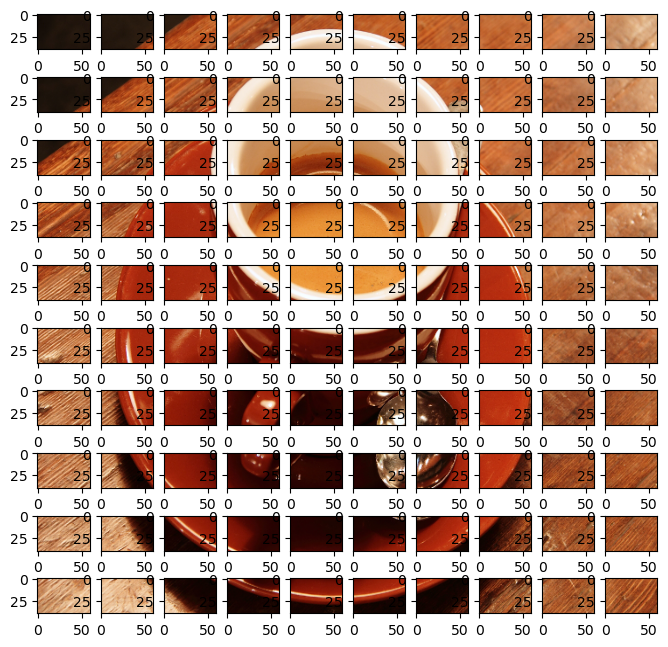

In [203]:
#Vemos que funciona correctamente:
mostrar_casillas(lista, 10, 10)

Necesitamos crear el hueco con el que iremos jugando.
<br>
El hueco siempre estará en la esquina inferior derecha, se podría escoger aleatoriamente de entre todos las posibles casillas, pero para comprobar si tiene o no solución una vez mezclado es más sencillo así.

In [5]:
def crear_hueco(lista):
    elem = lista[-1]
    ind = next((i for i, val in enumerate(lista) if np.all(val == elem)), -1)
    elem.fill(0)
    lista[ind] = elem
    return (lista, ind)

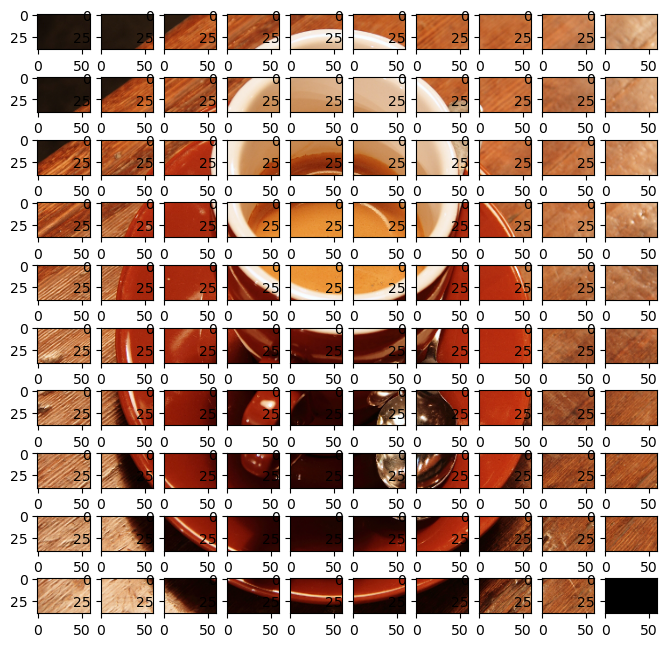

In [204]:
lista, ind_hueco = crear_hueco(lista)
mostrar_casillas(lista, 10, 10)

Ahora necesitamos un método que desordene nuestrás imágenes para el rompecabezas:

Primero hay que darse cuenta de una cosa, si desordenamos aleatoriamente, con un método como random.shuffle() corremos el riesgo de que el puzzle sea irresoluble. Para este tipo de rompecabezas, existe un concepto denominado "inversión":
<br>
<br>
 - Inversión: Es cualquier pareja de casillas/fichas que no se encuentran en el orden correcto.
 - Polaridad: Es el número total de inversiones, de modo que si el número de columnas es impar la polaridad deberá ser par para que tenga solución. En caso de que las columnas sean pares entonces la posición relativa del hueco a la última columna debera ser distinta de la paridad de la polaridad.

<br>
Esto se entiende bien con la siguiente tabla:
<br>
<table ><tr ><th >Numero de Columnas<th><th style="text-align: center"> Condición Solubilidad <th><tr>
<tr><td style="text-align: center"> Impar <td><td style="text-align: center"> Polaridad par <td><tr>
    <tr><td style="text-align: center"> Par <td><td style="text-align: center"> Paridad de la posición desde la última fila del hueco != Paridad de la polaridad<td><td><table>

Por ejemplo, si el hueco se encuentra en la última fila, eso es un uno, tenemos paridad impar. Por lo tanto, la polaridad tendrá que ser par.

Creamos una función que compruebe si la polaridad es par:

In [6]:
def solucion(indicesDesordenados, columnas, posHuecoFilaAbajo):
    polaridad = 0
    for i, actual in enumerate(indicesDesordenados):
        for siguiente in indicesDesordenados[i+1:]:
            if actual > siguiente:
                polaridad += 1
    if columnas%2 != 0:
        return polaridad % 2 == 0
    else: 
        if posHuecoFilaAbajo%2 != polaridad%2:
            return True
        else:
            return False

In [7]:
def desordenar_casillas(listaImagenes, indHueco, filas, columnas):
    hueco = listaImagenes[indHueco]
    indHuecoOr = indHueco
    
    while True:
        aux = list(enumerate(listaImagenes))
        random.shuffle(aux)
        indices, lista = zip(*aux)
        indices = list(indices)
        indices.remove(indHuecoOr)
        indHueco = next((i for i, val in enumerate(lista) if np.all(val == hueco)), -1)
        filaHueco = indHueco//columnas
        posHuecoFilaAbajo = filas - filaHueco
        if solucion(indices, columnas, posHuecoFilaAbajo) and not np.array_equal(lista,listaImagenes):
            break
        
    return list(lista), indHueco

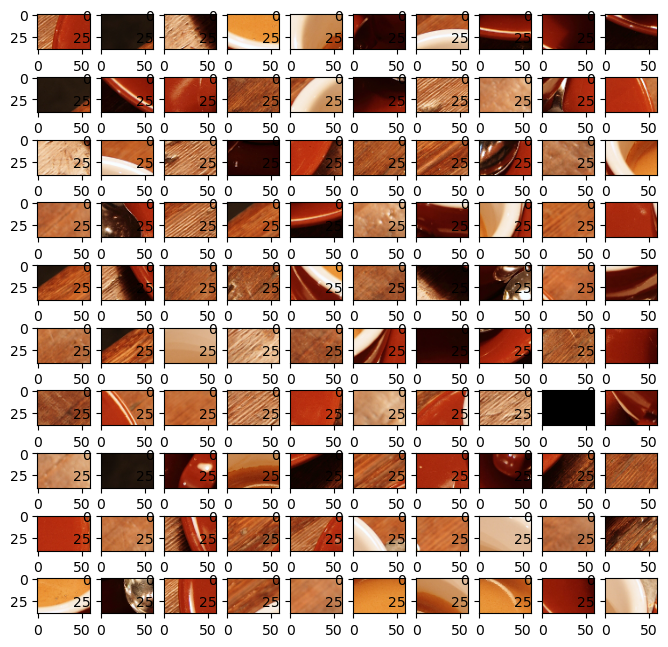

In [210]:
lista, ind_hueco = desordenar_casillas(lista, ind_hueco, 10, 10)
mostrar_casillas(lista, 10, 10)

Ahora implementamos el cambio entre casillas.

In [8]:
def intercambiar_casillas(lista, pos1, pos2):
    lista[pos1], lista[pos2] = lista[pos2], lista[pos1]

In [9]:
def puede_mover(posCas, posHueco, filas, columnas):
    if posCas - 1 == posHueco and posCas//columnas == posHueco//columnas:
        return True
    elif posCas + 1 == posHueco and posCas//columnas == posHueco//columnas:
        return True
    elif abs(posCas - posHueco) == columnas:
        return True
    else:
        return False

Hacemos la interfaz gráfica

Esta opción solo sirve para conseguir datos desde Google Collab.

filas = 10 #@param {type:"number"}
<br>
columnas = 10 #@param {type:"number"}

En este caso usaremos esta:

filas = int(input('Introduzca el número de filas: '))
<br>
columnas = int(input('Introduzca el número de columnas: '))

In [57]:
imagen = skimage.data.coffee()

Guardamos cada matriz de numpy en imagenes que usaremos para la interfaz:

In [10]:
def generar_casillas(lista):
    for i,elem in enumerate(lista):
        img = Image.fromarray(elem.astype('uint8'), 'RGB')
        img.save(f"Imagenes/casilla{i}.png")

In [11]:
def dibujar_rompecabezas(canvas, imagenes, F, C, W_I, H_I):
    for i in range(F):
        for j in range(C):
            canvas.blit(imagenes[C*i+j], (j*(W_I) , i*(H_I)))
    pygame.display.update()

In [12]:
def get_numero_casilla(pos, W_I, H_I, C):
    x, y = pos
    columna = x//W_I
    fila = y//H_I
    return fila*C + columna

In [13]:
def juego(imagen, lista, filas, columnas, ind_hueco, final):
    #Generamos la configuración:
    W = imagen.shape[1]
    H = imagen.shape[0]
    F = filas
    C = columnas
    W_I = lista[0].shape[1]
    H_I = lista[0].shape[0]
    TAMAÑO_CELDA = W_I*H_I
    S_S = W//C
    BLACK = (0,0,0)
    ind_hueco = ind_hueco
    
    pygame.init()
    pygame.display.set_caption("Trabajo de PCD")
    canvas = pygame.display.set_mode((W+(C-1), H+(F-1)))
    canvas.fill(BLACK)
    icon = pygame.image.load("cafe.png")
    icon.convert()
    pygame.display.set_icon(icon)


    imagenes = []

    for i in range(len(lista)):
        imagenes.append(pygame.image.load(f"Imagenes/casilla{i}.png"))
        imagenes[i].convert()

    dibujar_rompecabezas(canvas, imagenes, F, C, W_I, H_I)
    ejecutar = True
    while ejecutar:
        for event in pygame.event.get(): # Comprobar si se ha pulsado una tecla
            if event.type == pygame.QUIT:
                ejecutar = False
                for i in range(len(lista)):
                    os.remove(f"Imagenes/casilla{i}.png")
                pygame.display.quit()
                pygame.quit()
                sys.exit(0) # Salir del programa
            if event.type == pygame.MOUSEBUTTONUP:
                numero_cas = get_numero_casilla(event.pos, W_I, H_I, C)
                if puede_mover(numero_cas, ind_hueco, F, C):
                    intercambiar_casillas(imagenes, numero_cas, ind_hueco)
                    intercambiar_casillas(lista, numero_cas, ind_hueco)
                    ind_hueco = numero_cas
                dibujar_rompecabezas(canvas,imagenes,F, C, W_I, H_I)
                if np.array_equal(lista,final):
                    print("Enhorabuena")
                    ejecutar = False
                    for i in range(len(lista)):
                        os.remove(f"Imagenes/casilla{i}.png")
                    pygame.display.quit()
                    pygame.quit()
                    sys.exit(0) # Salir del programa

# Resultado final:

Aquí combinamos todo para obtener el puzle completo:

Para añadir nuevas imágenes al rompecabezas, habría que meterlas en la carpeta llamada "Recursos" y una vez añadida, sería escribir su nombre en el input correspondiente:

In [20]:
filas = int(input('Introduzca el número de filas: ')) #Es preferible que no se de el caso de filas y columnas 2x2.
columnas = int(input('Introduzca el número de columnas: '))
url = "Recursos/" + input('Introduzca la url relativa de la imagen: ') #En la carpeta envíada con el trabajo figuran varias imagenes, simplemente poniendo "cafe.png", por ejemplo, servirá.
#Por si no se desea escribir el nombre del archivo
#url = "Recursos/cafe.png"

Introduzca el número de filas: 4
Introduzca el número de columnas: 4
Introduzca la url relativa de la imagen: ajedrez.png


In [ ]:
imagen = np.asarray(Image.open(url).convert('RGB'))
lista = dividir_imagen(imagen, filas, columnas)
final = lista.copy()
lista, ind_hueco = crear_hueco(lista)
lista, ind_hueco = desordenar_casillas(lista, ind_hueco, filas, columnas)
#mostrar_casillas(lista, 3, 4)
generar_casillas(lista)
juego(imagen, lista, filas, columnas, ind_hueco, final)